# X2 Dimensionality Reduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py as h5
import torch as th

In [2]:
file_path = '/mnt/data/insync/braunphil/Public/datascience_miniproject/'
file_name = '02_VAE.npy'
data = np.load(file_path + file_name)
print(f"Data shape: {data.shape}")

In [9]:
ds = data.shape
data3d = data.reshape(ds[0]*ds[1], ds[2], ds[3])
print(f"Data3d shape: {data3d.shape}")

Data3d shape: (65536, 124, 124)


## Plot 3 images from data3d

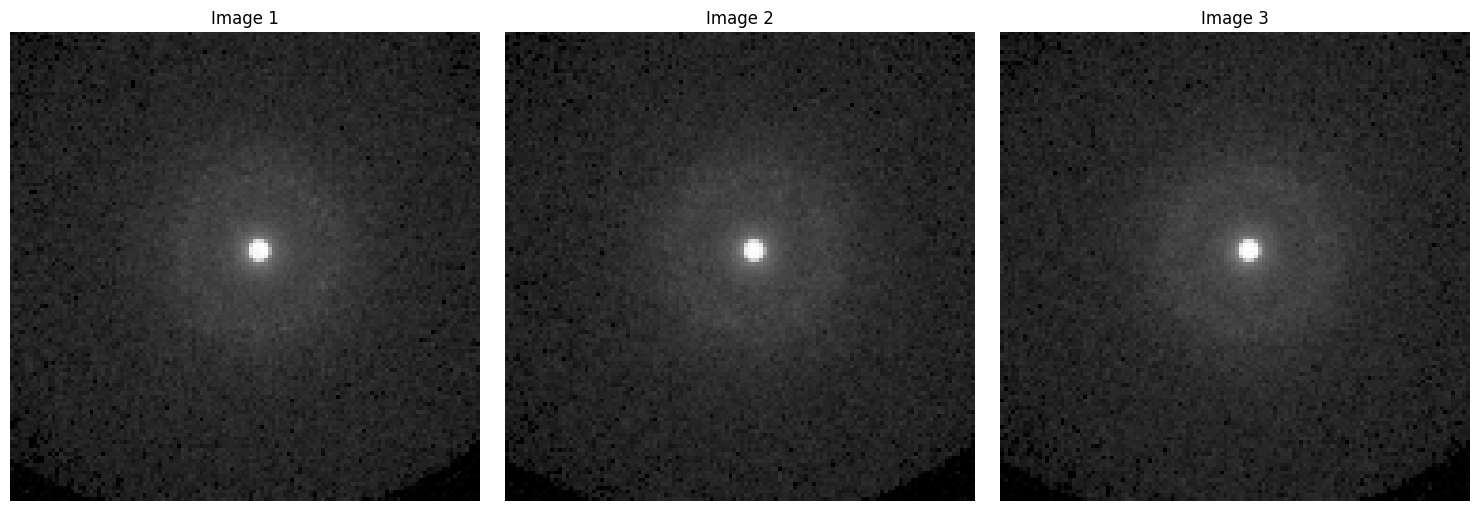

In [4]:

plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(data3d[i+1000]**0.25, cmap='gray')
    plt.title(f'Image {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


## Define the VAE architecture

In [5]:

class ConvVAE(th.nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
        
        # Encoder
        self.encoder = th.nn.Sequential(
            th.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            th.nn.ReLU(),
            th.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            th.nn.ReLU(),
            th.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            th.nn.ReLU(),
            th.nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            th.nn.ReLU(),
            th.nn.Flatten()
        )
        
        # Latent space
        self.fc_mu = th.nn.Linear(256 * 8 * 8, 3)
        self.fc_var = th.nn.Linear(256 * 8 * 8, 3)
        
        # Decoder
        self.decoder_input = th.nn.Linear(3, 256 * 8 * 8)
        
        self.decoder = th.nn.Sequential(
            th.nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            th.nn.ReLU(),
            th.nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            th.nn.ReLU(),
            th.nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            th.nn.ReLU(),
            th.nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            th.nn.Sigmoid()
        )
        
    def encode(self, x):
        x = self.encoder(x)
        mu = self.fc_mu(x)
        log_var = self.fc_var(x)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = th.exp(0.5 * log_var)
        eps = th.randn_like(std)
        return mu + eps * std
        
    def decode(self, z):
        x = self.decoder_input(z)
        x = x.view(-1, 256, 8, 8)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Initialize model
model = ConvVAE().cuda()

# Define loss function
def loss_function(recon_x, x, mu, log_var):
    BCE = th.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * th.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

# Initialize optimizer
optimizer = th.optim.Adam(model.parameters(), lr=1e-3)


In [6]:
# Print model architecture
print(model)


ConvVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (fc_mu): Linear(in_features=16384, out_features=3, bias=True)
  (fc_var): Linear(in_features=16384, out_features=3, bias=True)
  (decoder_input): Linear(in_features=3, out_features=16384, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1,

In [7]:
# Training loop
num_epochs = 3
batch_size = 32

data3dt = th.from_numpy(np.pad(data3d, ((0,0), (2,2), (2,2)))).float().unsqueeze(1).cuda()
data3dt -= data3dt.min()
data3dt /= data3dt.max()

In [8]:
# Create example input for tracing
example_input = data3dt[:1]
model.eval()
# Use torch.jit.trace to create a traced version of the model
traced_model = th.jit.trace(model, example_input)

# Replace the original model with the traced version
model = traced_model


for epoch in range(num_epochs):
    total_loss = 0
    num_batches = 0
    
    # Iterate over batches
    for i in range(0, len(data3dt), batch_size):
        batch = data3dt[i:i+batch_size]
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, log_var = model(batch)
        
        # Calculate loss
        loss = loss_function(recon_batch, batch, mu, log_var)
        
        # Backward pass
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    # Print progress
    avg_loss = total_loss / num_batches
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')


/home/philipp/mambaforge/envs/main11/lib/python3.11/site-packages/torch/jit/_trace.py:1116: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%eps : Float(1, 3, strides=[3, 1], requires_grad=0, device=cuda:0) = aten::randn_like(%std, %180, %181, %182, %183, %184) # /tmp/ipykernel_457356/3107499789.py:44:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _check_trace(
/home/philipp/mambaforge/envs/main11/lib/python3.11/site-packages/torch/jit/_trace.py:1116: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 16347 / 16384 (99.8%)
Greatest absolute difference: 0.04185950756072998 at index (0, 0, 39, 27) (up to 1e-05 allowed)
Greatest relative difference: 0.08788865663083263 at index (0, 0, 39, 27) (up to 1e-05 allowed)
  _check_trace(


Epoch [1/3], Average Loss: 8489.5454
Epoch [2/3], Average Loss: 6916.7546
Epoch [3/3], Average Loss: 6891.0922
